In [16]:
from utils.download_kaggle_dataset import download_kaggle_competition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

In [6]:
data = download_kaggle_competition("llm-classification-finetuning")
train_df = pd.read_csv(f"{data}/train.csv")
test_df = pd.read_csv(f"{data}/test.csv")

Unzipping files...
Competition data downloaded to: datasets


In [7]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print(train_df.info())
print(train_df.describe(include='all'))


Train shape: (57477, 9)
Test shape: (3, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB
None
                  id             model_a             model_b  \
count   5.747700e+04               57477               57477   
unique           NaN                  64                  64   
top              NaN  gpt-4-1106-preview  gpt-4-1106-preview   
freq             NaN                3678              

In [8]:
print("Missing in train_df:\n", train_df.isnull().sum())
print("Missing in test_df:\n", test_df.isnull().sum())


Missing in train_df:
 id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64
Missing in test_df:
 id            0
prompt        0
response_a    0
response_b    0
dtype: int64


In [14]:
print(train_df.columns)


Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie'],
      dtype='object')


In [17]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\smnav\AppData\Roaming\nltk_data...


True

In [18]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

Train shape: (57477, 9)
Test shape: (3, 4)
       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   
3  ["Creating a test set for a very rare category...   
4  ["The best w

In [19]:
def get_label(row):
    if row['winner_model_a']:
        return 'model_a'
    elif row['winner_model_b']:
        return 'model_b'
    else:
        return 'tie'

In [20]:
train_df['target'] = train_df.apply(get_label, axis=1)

C:\Users\smnav\AppData\Local\Temp\ipykernel_19760\1029734291.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train_df, palette='Set2')


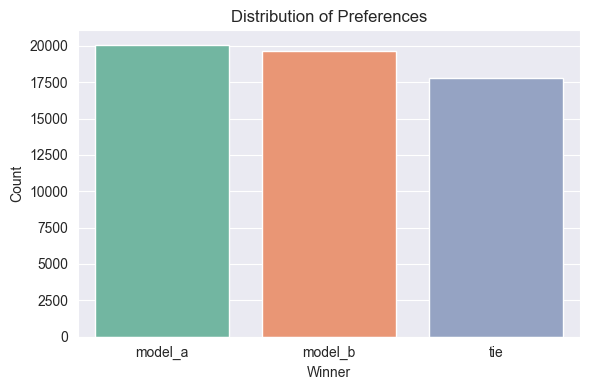

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df, palette='Set2')
plt.title("Distribution of Preferences")
plt.xlabel("Winner")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

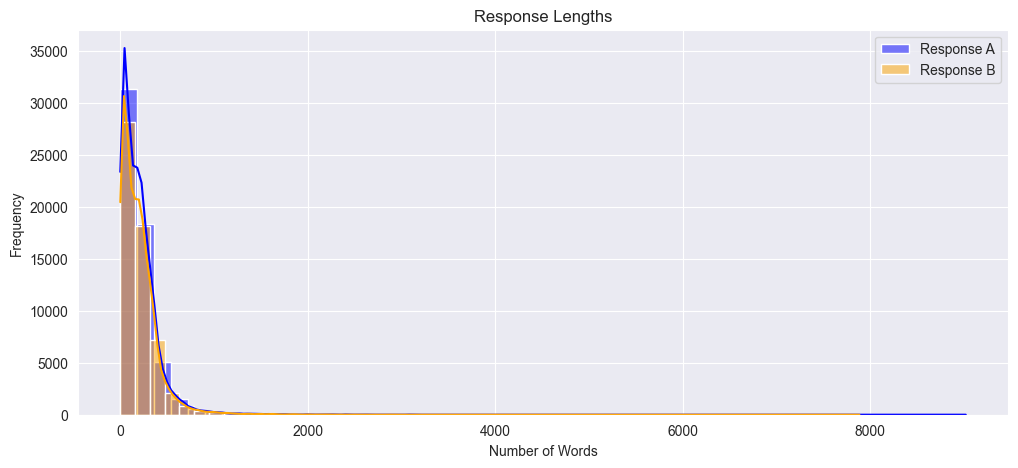

In [22]:
train_df['len_response_a'] = train_df['response_a'].apply(lambda x: len(str(x).split()))
train_df['len_response_b'] = train_df['response_b'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(train_df['len_response_a'], color='blue', label='Response A', kde=True, bins=50)
sns.histplot(train_df['len_response_b'], color='orange', label='Response B', kde=True, bins=50)
plt.legend()
plt.title("Response Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

C:\Users\smnav\AppData\Local\Temp\ipykernel_19760\79781632.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='winner_model_a', data=train_df, palette='coolwarm')


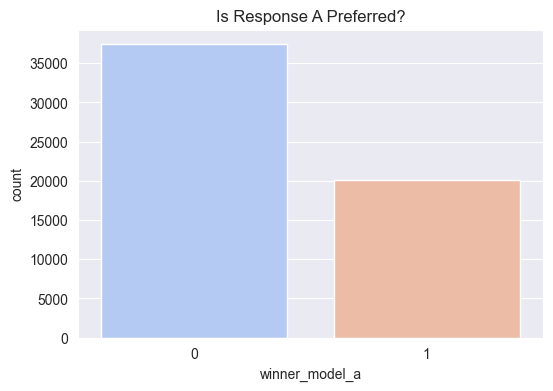

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x='winner_model_a', data=train_df, palette='coolwarm')
plt.title("Is Response A Preferred?")
plt.show()

C:\Users\smnav\AppData\Local\Temp\ipykernel_19760\89418365.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['response_a_sentiment'], label='Response A', shade=True)
C:\Users\smnav\AppData\Local\Temp\ipykernel_19760\89418365.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['response_b_sentiment'], label='Response B', shade=True)


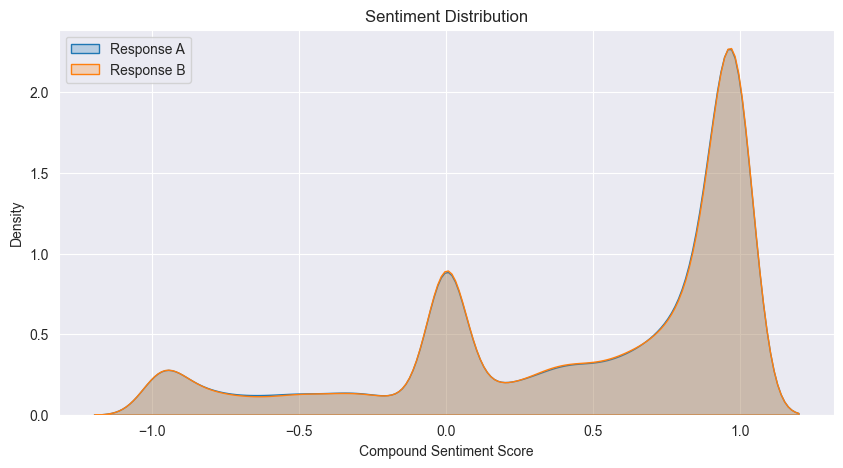

In [24]:
sia = SentimentIntensityAnalyzer()

for col in ['response_a', 'response_b']:
    train_df[f'{col}_sentiment'] = train_df[col].apply(lambda x: sia.polarity_scores(x)['compound'])

plt.figure(figsize=(10, 5))
sns.kdeplot(train_df['response_a_sentiment'], label='Response A', shade=True)
sns.kdeplot(train_df['response_b_sentiment'], label='Response B', shade=True)
plt.title("Sentiment Distribution")
plt.xlabel("Compound Sentiment Score")
plt.legend()
plt.show()

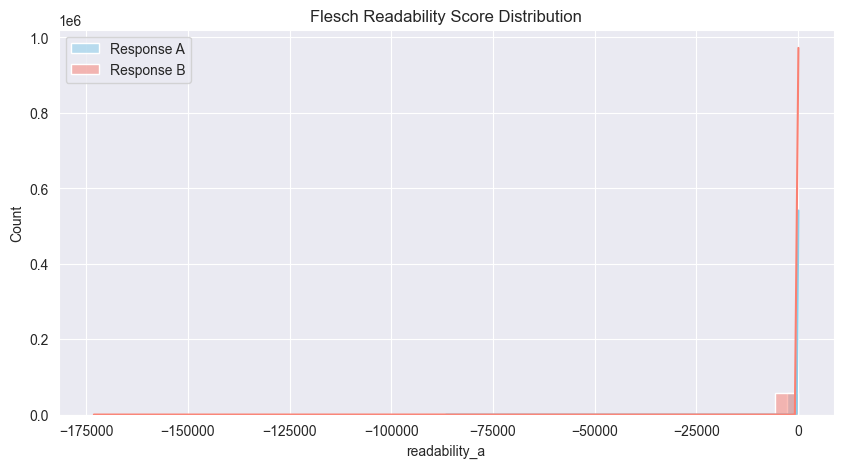

In [25]:
train_df['readability_a'] = train_df['response_a'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
train_df['readability_b'] = train_df['response_b'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

plt.figure(figsize=(10, 5))
sns.histplot(train_df['readability_a'], color='skyblue', label='Response A', kde=True, bins=30)
sns.histplot(train_df['readability_b'], color='salmon', label='Response B', kde=True, bins=30)
plt.title("Flesch Readability Score Distribution")
plt.legend()
plt.show()


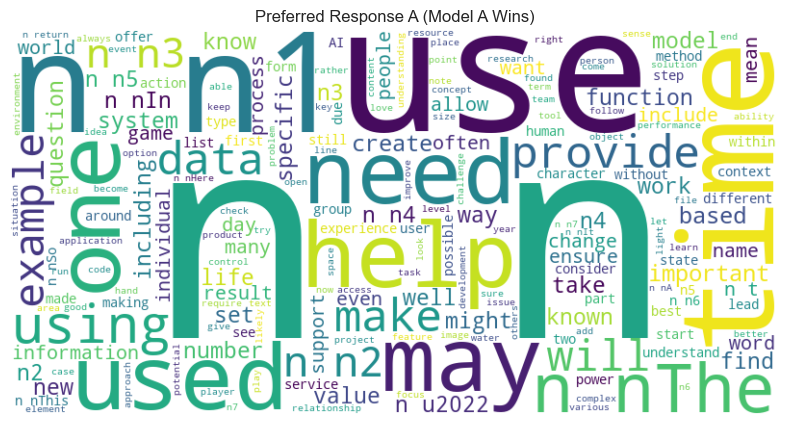

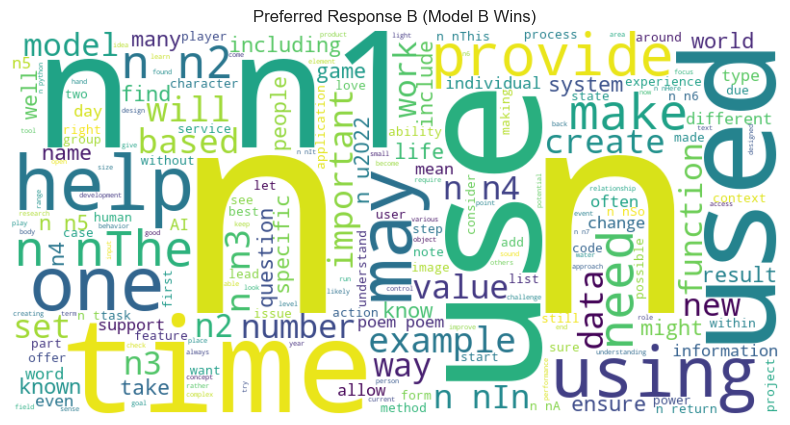

In [26]:
def generate_wordcloud(text_series, title):
    text = " ".join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(train_df[train_df['target'] == 'model_a']['response_a'], "Preferred Response A (Model A Wins)")
generate_wordcloud(train_df[train_df['target'] == 'model_b']['response_b'], "Preferred Response B (Model B Wins)")


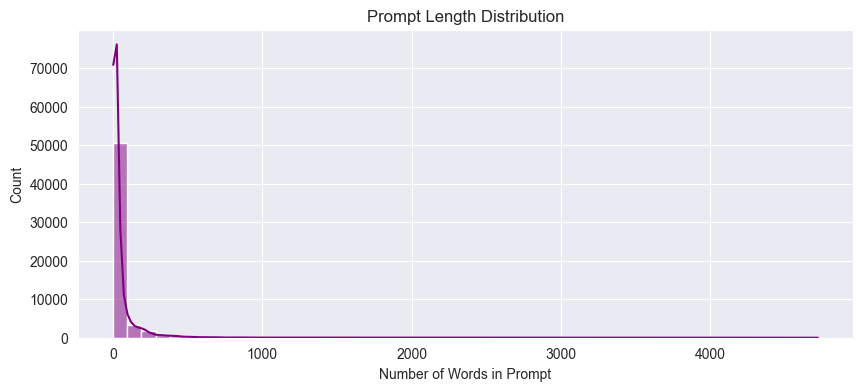

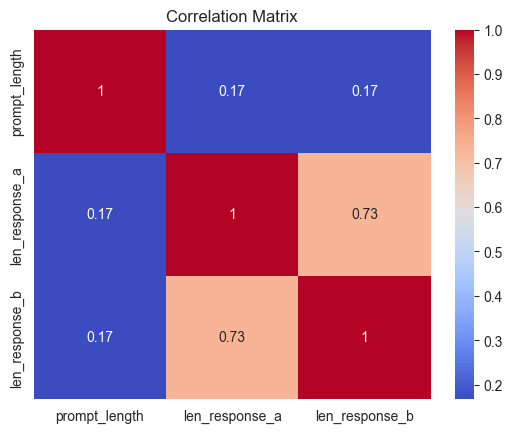

In [27]:
train_df['prompt_length'] = train_df['prompt'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 4))
sns.histplot(train_df['prompt_length'], bins=50, kde=True, color='purple')
plt.title("Prompt Length Distribution")
plt.xlabel("Number of Words in Prompt")
plt.show()

# Correlation with prompt length
corrs = train_df[['prompt_length', 'len_response_a', 'len_response_b']].corr()
sns.heatmap(corrs, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()